In [1]:
### imporitng lib

In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
warnings.filterwarnings("ignore")

In [7]:
from causalnex.structure.notears import from_pandas
from causalnex.structure import StructureModel

In [9]:
from IPython.display import Image
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE
from sklearn.preprocessing import LabelEncoder
from causalnex.discretiser import Discretiser
from causalnex.network import BayesianNetwork
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, f1_score, accuracy_score, precision_score
from causalnex.inference import InferenceEngine

In [10]:
sns.set()
%matplotlib inline
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option("expand_frame_repr", False)
pd.set_option('display.float_format', '{:.2f}'.format)

In [13]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join('../scripts')))

###### importing modules

In [17]:
from file import Myfile
from utils import Utils

In [18]:
file = Myfile()
utils = Utils()

###### Load data

load the data that prepared during EDA for the causal graph

In [21]:
#df = file.read_csv("../data/causaldata.csv")
df = file.read_csv("C:/Users/Ekubazgi/Desktop/data/causaldata.csv")

--> file read as csv


In [25]:
cols = ['Trip Start Time','Trip End Time']
df = df.drop(columns=cols)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1555718 entries, 0 to 1555717
Data columns (total 8 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   Trip ID           1555718 non-null  int64  
 1   Trip Origin       1555718 non-null  object 
 2   Trip Destination  1555718 non-null  object 
 3   Distance          1555718 non-null  float64
 4   Speed             1555718 non-null  float64
 5   driver_action     1555718 non-null  object 
 6   is_weekend        1555718 non-null  int64  
 7   is_holiday        1555718 non-null  int64  
dtypes: float64(2), int64(3), object(3)
memory usage: 95.0+ MB


In [27]:
df.head(3)

,Trip ID,Trip Origin,Trip Destination,Distance,Speed,driver_action,is_weekend,is_holiday
0,392001,"6.6010417,3.2766339","6.4501069,3.3916154",20.98,217.00,accepted,0,0
1,392001,"6.6010417,3.2766339","6.4501069,3.3916154",20.98,217.00,rejected,0,0
2,392001,"6.6010417,3.2766339","6.4501069,3.3916154",20.98,217.00,rejected,0,0


In [28]:
df.shape

(1555718, 8)

###### Label Encoding
change catagorical variable to numeric variable

In [30]:
non_num_cols = list(df.select_dtypes(exclude=[np.number]).columns)
le = LabelEncoder()
for col in non_num_cols:
    df[col] = le.fit_transform(df[col])


In [31]:
df.head(3)

,Trip ID,Trip Origin,Trip Destination,Distance,Speed,driver_action,is_weekend,is_holiday
0,392001,11676,3785,20.98,217.00,0,0,0
1,392001,11676,3785,20.98,217.00,1,0,0
2,392001,11676,3785,20.98,217.00,1,0,0


In [65]:
# initializing the structural model
model = StructureModel()

In [97]:
#selecting the dataset used to construct the causal graph
x_df = df.head(50000)

reaname the columns for further readablity

In [98]:
dict = {'Trip Origin': 'Tr_Origin',
        'Trip ID': 'Ord_id',
        'Trip Destination': 'Tr_Dest',
        }

x_df.rename(columns=dict,
          inplace=True)

In [99]:
model = from_pandas(x_df)

###### Visualization

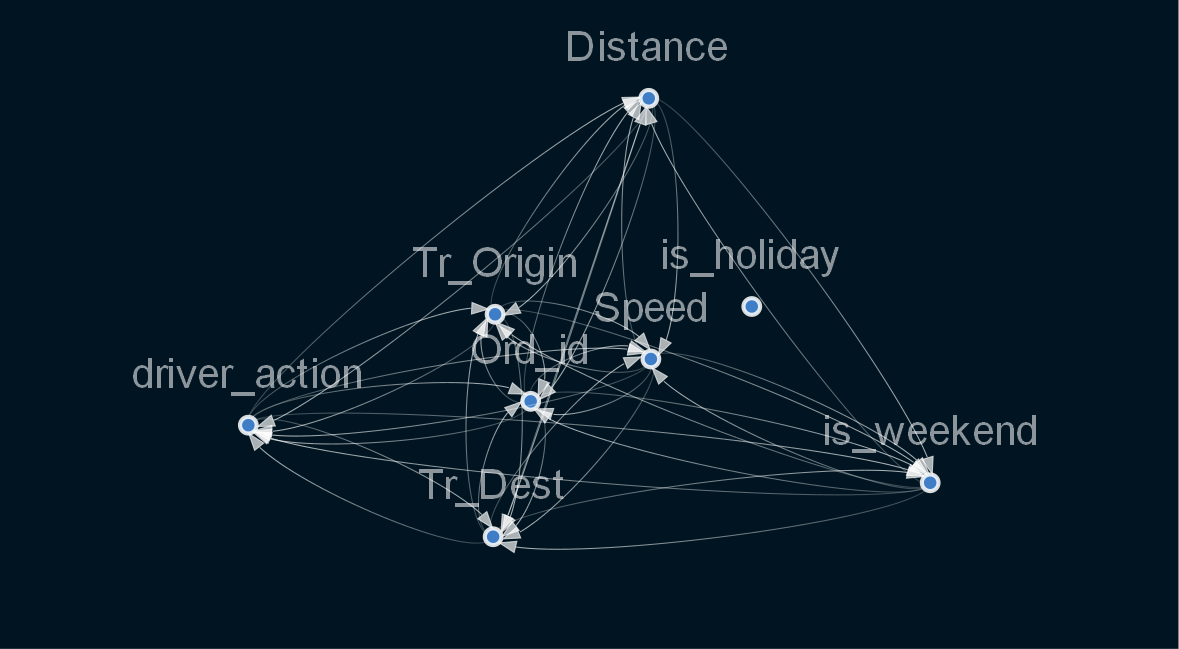

In [100]:
v = plot_structure(
    model,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
    prog='fdp',
)
Image(v.draw(format='png'))

###### removing edges with low threshold

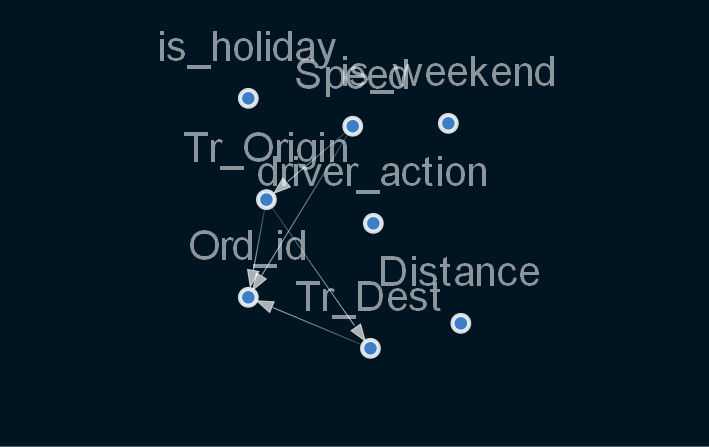

In [102]:
model.remove_edges_below_threshold(0.8)
v = plot_structure(
    model,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
)
Image(v.draw(format='png'))

speed affects Order_id - orders may be delay.
Trip_origion and Trip_Destination also affects order id.

###### Stablity

In [103]:
#checking with 80%
portion = int(x_df.shape[0] *.80)
x_portion = x_df.head(portion)

CPU times: total: 11.7 s
Wall time: 4.68 s


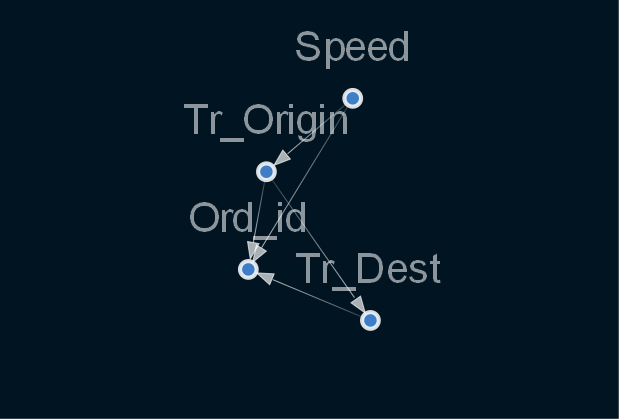

In [104]:
%%time
model1 = from_pandas(x_portion)
model1.remove_edges_below_threshold(0.8)
model1 = model1.get_largest_subgraph()
v = plot_structure(
    model1,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
)
Image(v.draw(format='png'))

In [73]:
#checking with 95%
portion = int(x_df.shape[0] *.95)
x_portion = x_df.head(portion)

CPU times: total: 9.36 s
Wall time: 4.16 s


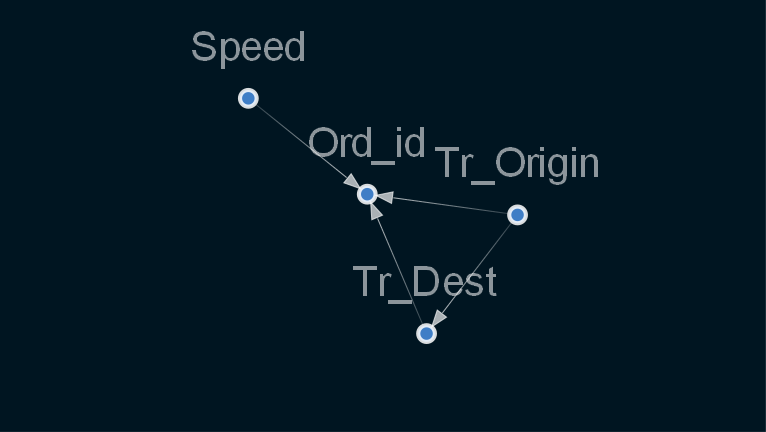

In [74]:
%%time
model2 = from_pandas(x_portion)
model2.remove_edges_below_threshold(0.8)

model2 = model1.get_largest_subgraph()
v = plot_structure(
    model2,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
)
Image(v.draw(format='png'))

In [75]:
def jaccard_similarity(g,h):
    i = set(g).intersection(h)
    return round(len(i)/(len(g) + len(h) - len(i)),3)

In [76]:
jaccard_similarity(model2.edges, model1.edges)

1.0

The jaccard_similarity shows no difference between the causal graphs

###### Fitting the Conditional Distribution of the Bayesian Network

In [77]:
bn = BayesianNetwork(model2)

Preparing the Discretised Data

In [78]:
disc_df = x_df.copy()

In [79]:
disc_df.tail(3)

,Ord_id,Tr_Origin,Tr_Dest,Distance,Speed,driver_action,is_weekend,is_holiday
1555715,517948,1949,7036,8.11,6167.00,1,0,0
1555716,517948,1949,7036,8.11,6167.00,1,0,0
1555717,517948,1949,7036,8.11,6167.00,1,0,0


In [80]:
#To make numeric features categorical, they must first be discretised.

disc_df["Distance"] = Discretiser(method="fixed",
                          numeric_split_points=[10]).transform(disc_df["Distance"].values)
disc_df["Speed"] = Discretiser(method="fixed",
                          numeric_split_points=[10]).transform(disc_df["Speed"].values)
disc_df["Ord_id"] = Discretiser(method="fixed",
                          numeric_split_points=[10]).transform(disc_df["Ord_id"].values)
disc_df["Tr_Origin"] = Discretiser(method="fixed",
                          numeric_split_points=[10]).transform(disc_df["Tr_Origin"].values)
disc_df["Tr_Dest"] = Discretiser(method="fixed",
                          numeric_split_points=[10]).transform(disc_df["Tr_Dest"].values)


In [81]:
disc_df.tail(3)

,Ord_id,Tr_Origin,Tr_Dest,Distance,Speed,driver_action,is_weekend,is_holiday
1555715,1,1,1,0,1,1,0,0
1555716,1,1,1,0,1,1,0,0
1555717,1,1,1,0,1,1,0,0


###### Train / Test Split

In [82]:
train, test = train_test_split(disc_df, train_size=0.9, test_size=0.1, random_state=27)

###### Model Probability

In [83]:
bn = bn.fit_node_states(disc_df)

###### Fit Conditional Probability Distributions

In [85]:
bn = bn.fit_cpds(train, method="BayesianEstimator", bayes_prior="K2")

In [88]:
pred = bn.predict(test, 'Speed')
true = test['Speed']
pred

,Speed_prediction
1544730,1
1508641,1
1533636,1
1506834,1
1529353,1
...,...
1515651,1
1551552,1
1523000,1
1525280,1


In [89]:
print('Accuracy: {:.2f} '.format(accuracy_score(y_true=true, y_pred=pred)))
print('Precision: {:.2f} '.format(precision_score(y_true=true, y_pred=pred)))

Accuracy: 1.00 
Precision: 1.00 


###### Inference

In [90]:
# creating inference engine
eng = InferenceEngine(bn)

In [91]:
act =eng.query()
act['Speed']

{1: 1.0}

In [94]:
obser_1 = {"Ord_id":1, "Speed": 1}
obser_2 = {"Ord_id":1, "Tr_Origin": 1}
fullfulment = eng.query([obser_1, obser_2])

In [96]:
for d in fullfulment:
    print(d['Speed'])

{1: 1.0}
{1: 1.0}
